**CS224W Final Project - Maya, Gabe, Kevin**

In this colab, we will walk through how to implement and utilize some of the sampling functions in PyTorch Geometric.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We are using a SNAP dataset, which we download from Google Drive and read into a pandas dataframe. You can use any method to upload the csv files.

In [ ]:
#import the data
import pandas as pd
import json
#edge dataframe, nodes indexed from 0
chameleon_edges_df=pd.read_csv('/content/gdrive/MyDrive/musae_chameleon_edges.csv')
squirrel_edges_df=pd.read_csv('/content/gdrive/MyDrive/musae_squirrel_edges.csv')
croc_edges_df=pd.read_csv('/content/gdrive/MyDrive/musae_crocodile_edges.csv')


#each page and its average monthly traffic
chameleon_target_df=pd.read_csv('/content/gdrive/MyDrive/musae_chameleon_target.csv')
squirrel_target_df=pd.read_csv('/content/gdrive/MyDrive/musae_squirrel_target.csv')
croc_target_df=pd.read_csv('/content/gdrive/MyDrive/musae_crocodile_target.csv')


#json files, key: page, value: nouns that appeared in the page
with open('/content/gdrive/MyDrive/musae_chameleon_features.json', 'r') as json_file:
        chameleon_features = json.load(json_file)

with open('/content/gdrive/MyDrive/musae_squirrel_features.json', 'r') as json_file:
        squirrel_features = json.load(json_file)

with open('/content/gdrive/MyDrive/musae_crocodile_features.json', 'r') as json_file:
        croc_features = json.load(json_file)



In [ ]:
chameleon_edges_df.head() #peek at the first couple entries in the dataframe to see the structure of it

,id1,id2
0,2034,1939
1,2034,2263
2,2034,1976
3,2034,2234
4,2034,804


In [ ]:
#create network graph of chameleon data
import networkx as nx
G = nx.from_pandas_edgelist(chameleon_edges_df, source='id1', target='id2')
#nx.draw(G, node_size=10, width=1.0, with_labels=True)

In [ ]:
#get graph metrics
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.density(G))

2277
31421
0.01212592031725523


Once the data has been loaded into colab, we install torch_geometric

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling

In [ ]:
#takes in nx.Graph, returns edge list as list of tuples
def graph_to_edge_list(G):
  return list(G.edges)

#takes in edge list and returns it as a long tensor list
def edge_list_to_tensor(edge_list):
  edge_index = torch.LongTensor(edge_list).T

  return edge_index

pos_edge_list = graph_to_edge_list(G)
#print(pos_edge_list)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
#print(pos_edge_index)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))

The pos_edge_index tensor has shape torch.Size([2, 31421])


In the below cell we generate the negative samples that we use during the training/testing

In [ ]:
data = Data(edge_index=pos_edge_index)
neg_edge_index = negative_sampling(pos_edge_index, num_nodes=data.num_nodes)

# print("Original edges:", pos_edge_index)
# print("Negative edges:", neg_edge_index)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [ ]:
#create embeddings for the nodes
import torch.nn as nn
from sklearn.decomposition import PCA

#create initial embeddings for the nodes
torch.manual_seed(1)

def create_node_emb(num_nodes, embedding_dim):
  emb = nn.Embedding(num_nodes, embedding_dim)
  emb.weight.data = torch.rand(emb.weight.data.shape)
  return emb

embedding_dim = 10 #can change the embedding dimension as needed
emb = create_node_emb(G.number_of_nodes(),embedding_dim)

print("Embedding: {}".format(emb))


Embedding: Embedding(2277, 10)


In the cell below we define our accuracy metrics

In [ ]:
#accuracy calculation
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):

  accu = 0.0
  accu = torch.sum(torch.round(pred) == label) / pred.shape[0]

  return accu
loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

Creating Metric Functions such as F1 Score

In [ ]:
def calculate_precision(preds, labels):
    true_positives = torch.sum((preds == 1) & (labels == 1)).float()
    predicted_positives = torch.sum(preds == 1).float()
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    return precision

def calculate_recall(preds, labels):
    true_positives = torch.sum((preds == 1) & (labels == 1)).float()
    actual_positives = torch.sum(labels == 1).float()
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    return recall

def calculate_f1_score(preds, labels):
    # Convert probabilities to binary predictions
    binary_preds = torch.round(preds)

    precision = calculate_precision(binary_preds, labels)
    recall = calculate_recall(binary_preds, labels)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

###Training

In [ ]:
#training
def train(emb, loss_fn, sigmoid, train_label, train_edge):

  epochs = 2500 #can adjust
  learning_rate = 0.1 #can adjust
  x_vals = []
  y1_vals = []
  y2_vals = []
  y3_vals = []

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad() #clear gradients
    embeddings = emb(train_edge)
    dot_prod = torch.sum(embeddings[0] * embeddings[1],axis = 1)
    pred = sigmoid(dot_prod)
    loss = loss_fn(pred, train_label)

    acc = round(accuracy(pred, train_label).item(), 4)

    # Convert predictions to binary for F1 score calculation
    binary_preds = torch.round(pred)
    f1 = calculate_f1_score(binary_preds, train_label)
    y3_vals.append(f1)

    x_vals.append(i)
    y1_vals.append(acc)
    y2_vals.append(loss.item())
    print("Epoch: ", i, "Loss: ", loss.item(), "Acc:", acc, "F1:", f1.item())

    loss.backward()
    optimizer.step()
  return x_vals, y1_vals, y2_vals, y3_vals

###Testing

In [ ]:
#test function
def test(emb, loss_fn, sigmoid, test_label, test_edge):

  epochs = 2500 #can adjust
  learning_rate = 0.1 #can adjust

  x_vals = []
  y1_vals = []
  y2_vals = []
  y3_vals = []

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad() #clear gradients
    embeddings = emb(test_edge)
    dot_prod = torch.sum(embeddings[0] * embeddings[1],axis = 1)
    pred = sigmoid(dot_prod)
    loss = loss_fn(pred, test_label)

    acc = round(accuracy(pred, test_label).item(), 4)

    # Convert predictions to binary for F1 score calculation
    binary_preds = torch.round(pred)
    f1 = calculate_f1_score(binary_preds, test_label)


    x_vals.append(i)
    y1_vals.append(acc)
    y2_vals.append(loss.item())
    y3_vals.append(f1)
    print("Epoch: ", i, "Loss: ", loss.item(), "Acc:", acc, "F1:", f1.item())

    loss.backward()
    optimizer.step()
  return x_vals, y1_vals, y2_vals, y3_vals


### Creating Data Splits
In this section we partition the data according to our negative sampling methods, and we begin training

In [ ]:
#generate training dataset
num_columns = pos_edge_index.shape[1]
split = int(num_columns * 0.8) #80% of data is training
print(split)


# Generate the positive and negative labels
pos_label = torch.ones(split, )
neg_label = torch.zeros(split, )
print(pos_label.shape)

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
#train_label = pos_label
print(train_label.shape)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index[:, :split], neg_edge_index[:, :split]], dim=1)
#train_edge = pos_edge_index[:, :split]
print(train_edge.shape)

x_vals, y1_vals, y2_vals, y3_vals = train(emb, loss_fn, sigmoid, train_label, train_edge)

25136
torch.Size([25136])
torch.Size([50272])
torch.Size([2, 50272])
Epoch:  0 Loss:  1.3498038053512573 Acc: 0.5 F1: 0.6666666865348816
Epoch:  1 Loss:  1.3497174978256226 Acc: 0.5 F1: 0.6666666865348816
Epoch:  2 Loss:  1.3495537042617798 Acc: 0.5 F1: 0.6666666865348816
Epoch:  3 Loss:  1.3493202924728394 Acc: 0.5 F1: 0.6666666865348816
Epoch:  4 Loss:  1.3490238189697266 Acc: 0.5 F1: 0.6666666865348816
Epoch:  5 Loss:  1.3486711978912354 Acc: 0.5 F1: 0.6666666865348816
Epoch:  6 Loss:  1.3482675552368164 Acc: 0.5 F1: 0.6666666865348816
Epoch:  7 Loss:  1.3478188514709473 Acc: 0.5 F1: 0.6666666865348816
Epoch:  8 Loss:  1.347329020500183 Acc: 0.5 F1: 0.6666666865348816
Epoch:  9 Loss:  1.3468023538589478 Acc: 0.5 F1: 0.6666666865348816
Epoch:  10 Loss:  1.3462424278259277 Acc: 0.5 F1: 0.6666666865348816
Epoch:  11 Loss:  1.3456535339355469 Acc: 0.5 F1: 0.6666666865348816
Epoch:  12 Loss:  1.3450376987457275 Acc: 0.5 F1: 0.6666666865348816
Epoch:  13 Loss:  1.3443981409072876 Acc: 0.5

In [ ]:
#generating testing dataset
num_columns = pos_edge_index.shape[1]
print(num_columns)
split = int(num_columns * 0.8)
print(split)


# Generate the positive and negative labels
pos_label = torch.ones(num_columns - split, )
neg_label = torch.zeros(num_columns - split, )
print(pos_label.shape)

# Concat positive and negative labels into one tensor
test_label = torch.cat([pos_label, neg_label], dim=0)
print(test_label.shape)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
test_edge = torch.cat([pos_edge_index[:, split:], neg_edge_index[:, split:]], dim=1)
print(test_edge.shape)

x_vals_test, y1_vals_test, y2_vals_test, y3_vals_test = test(emb, loss_fn, sigmoid, test_label, test_edge)

31421
25136
torch.Size([6285])
torch.Size([12570])
torch.Size([2, 12570])
Epoch:  0 Loss:  0.7657852172851562 Acc: 0.5034 F1: 0.6575974225997925
Epoch:  1 Loss:  0.7657551169395447 Acc: 0.5034 F1: 0.6575974225997925
Epoch:  2 Loss:  0.765697717666626 Acc: 0.5034 F1: 0.6575974225997925
Epoch:  3 Loss:  0.7656158804893494 Acc: 0.5035 F1: 0.6576334238052368
Epoch:  4 Loss:  0.7655121684074402 Acc: 0.5035 F1: 0.6576334238052368
Epoch:  5 Loss:  0.7653886675834656 Acc: 0.5035 F1: 0.6576334238052368
Epoch:  6 Loss:  0.7652474045753479 Acc: 0.5036 F1: 0.6576694846153259
Epoch:  7 Loss:  0.76509028673172 Acc: 0.5037 F1: 0.6577792167663574
Epoch:  8 Loss:  0.7649188041687012 Acc: 0.5037 F1: 0.6577792167663574
Epoch:  9 Loss:  0.7647345662117004 Acc: 0.5037 F1: 0.6577792167663574
Epoch:  10 Loss:  0.7645387649536133 Acc: 0.5037 F1: 0.6577792167663574
Epoch:  11 Loss:  0.76433265209198 Acc: 0.5038 F1: 0.6578528881072998
Epoch:  12 Loss:  0.7641171813011169 Acc: 0.5038 F1: 0.6578528881072998
Epoch

## Visualization

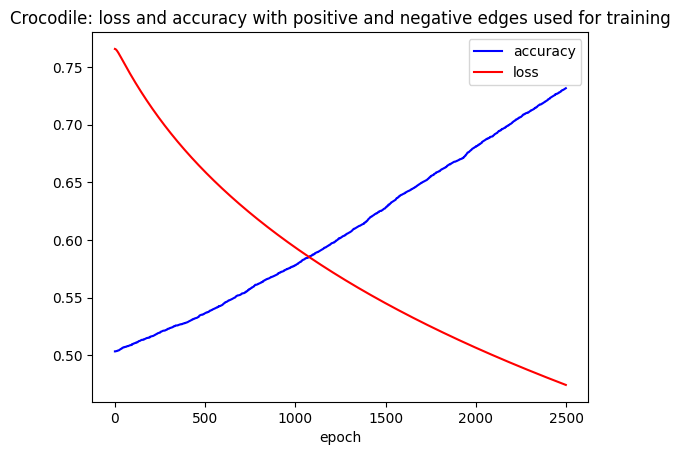

In [ ]:
import matplotlib.pyplot as plt

# plotting the epochs against accuracy and loss

# Create a new figure for plotting
plt.figure()

# Plot y1 against x
plt.plot(x_vals_test, y1_vals_test, label='accuracy', color='blue')

# Plot y2 against x on the same plot
plt.plot(x_vals_test, y2_vals_test, label='loss', color='red')

# Add labels and title (optional)
plt.xlabel('epoch')
plt.title('Crocodile: loss and accuracy with positive and negative edges used for training')

# Add a legend to explain which line is which
plt.legend()

# Show the plot
plt.show()


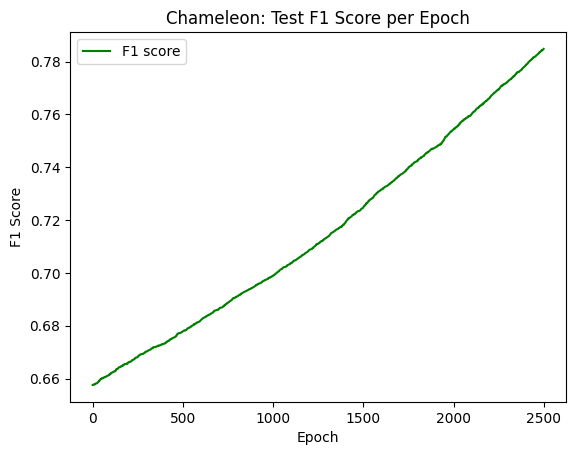

In [ ]:
# Create a new figure for plotting
plt.figure()

# Plot F1 score against epochs
plt.plot(x_vals_test, y3_vals_test, label='F1 score', color='green')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Chameleon: Test F1 Score per Epoch')

# Add a legend
plt.legend()

# Show the plot
plt.show()